In [5]:
import os
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.dataio import load_mat, load_log
from utils.visualization import *

DATA_DIR = '../data/'
results_path = '../results/'
RESULTS_DIR = '../results_new/numerical/'

### Load Images

In [6]:
IP_gt = load_mat(os.path.join(DATA_DIR, 'IP.mat'))
IP_das = load_mat(os.path.join(RESULTS_DIR, 'DAS', 'v_das=1510.0m·s⁻¹', 'IP_rec.mat'))
IP_dual_das = load_mat(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', 'v_body=1561.0m·s⁻¹', 'IP_rec.mat'))
IP_apact = load_mat(os.path.join(results_path, 'apact_simulation_easy.mat'))
IP_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'IP_rec.mat'))

SOS_gt = load_mat(os.path.join(DATA_DIR, 'SoS.mat'))
SOS_uniform = load_mat(os.path.join(DATA_DIR, 'SoS_uniform.mat'))
SOS_dual = load_mat(os.path.join(DATA_DIR, 'SoS_SB.mat'))
SOS_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'SOS_rec.mat'))
SOS_APACT = np.ones_like(SOS_gt) * 1500

t_das = load_log(os.path.join(RESULTS_DIR, 'DAS', 'v_das=1510.0m·s⁻¹', 'log.json'))['time']
t_dual_das = load_log(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', 'v_body=1561.0m·s⁻¹', 'log.json'))['time']
t_apact = 3000
t_nf_apact = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_1lyrs_64fts_TV=5.0e-05_lr=1.0e-04_30iters', 'log.json'))['time']

In [7]:
[IP_gt, IP_das, IP_dual_das, IP_apact, IP_nf_apact] = \
    [standardize(img) for img in [IP_gt, IP_das, IP_dual_das, IP_apact, IP_nf_apact]]
data_range_img = IP_das.max() - IP_das.min()
data_range_SOS = SOS_gt.max() - SOS_gt.min()

### Create Figure

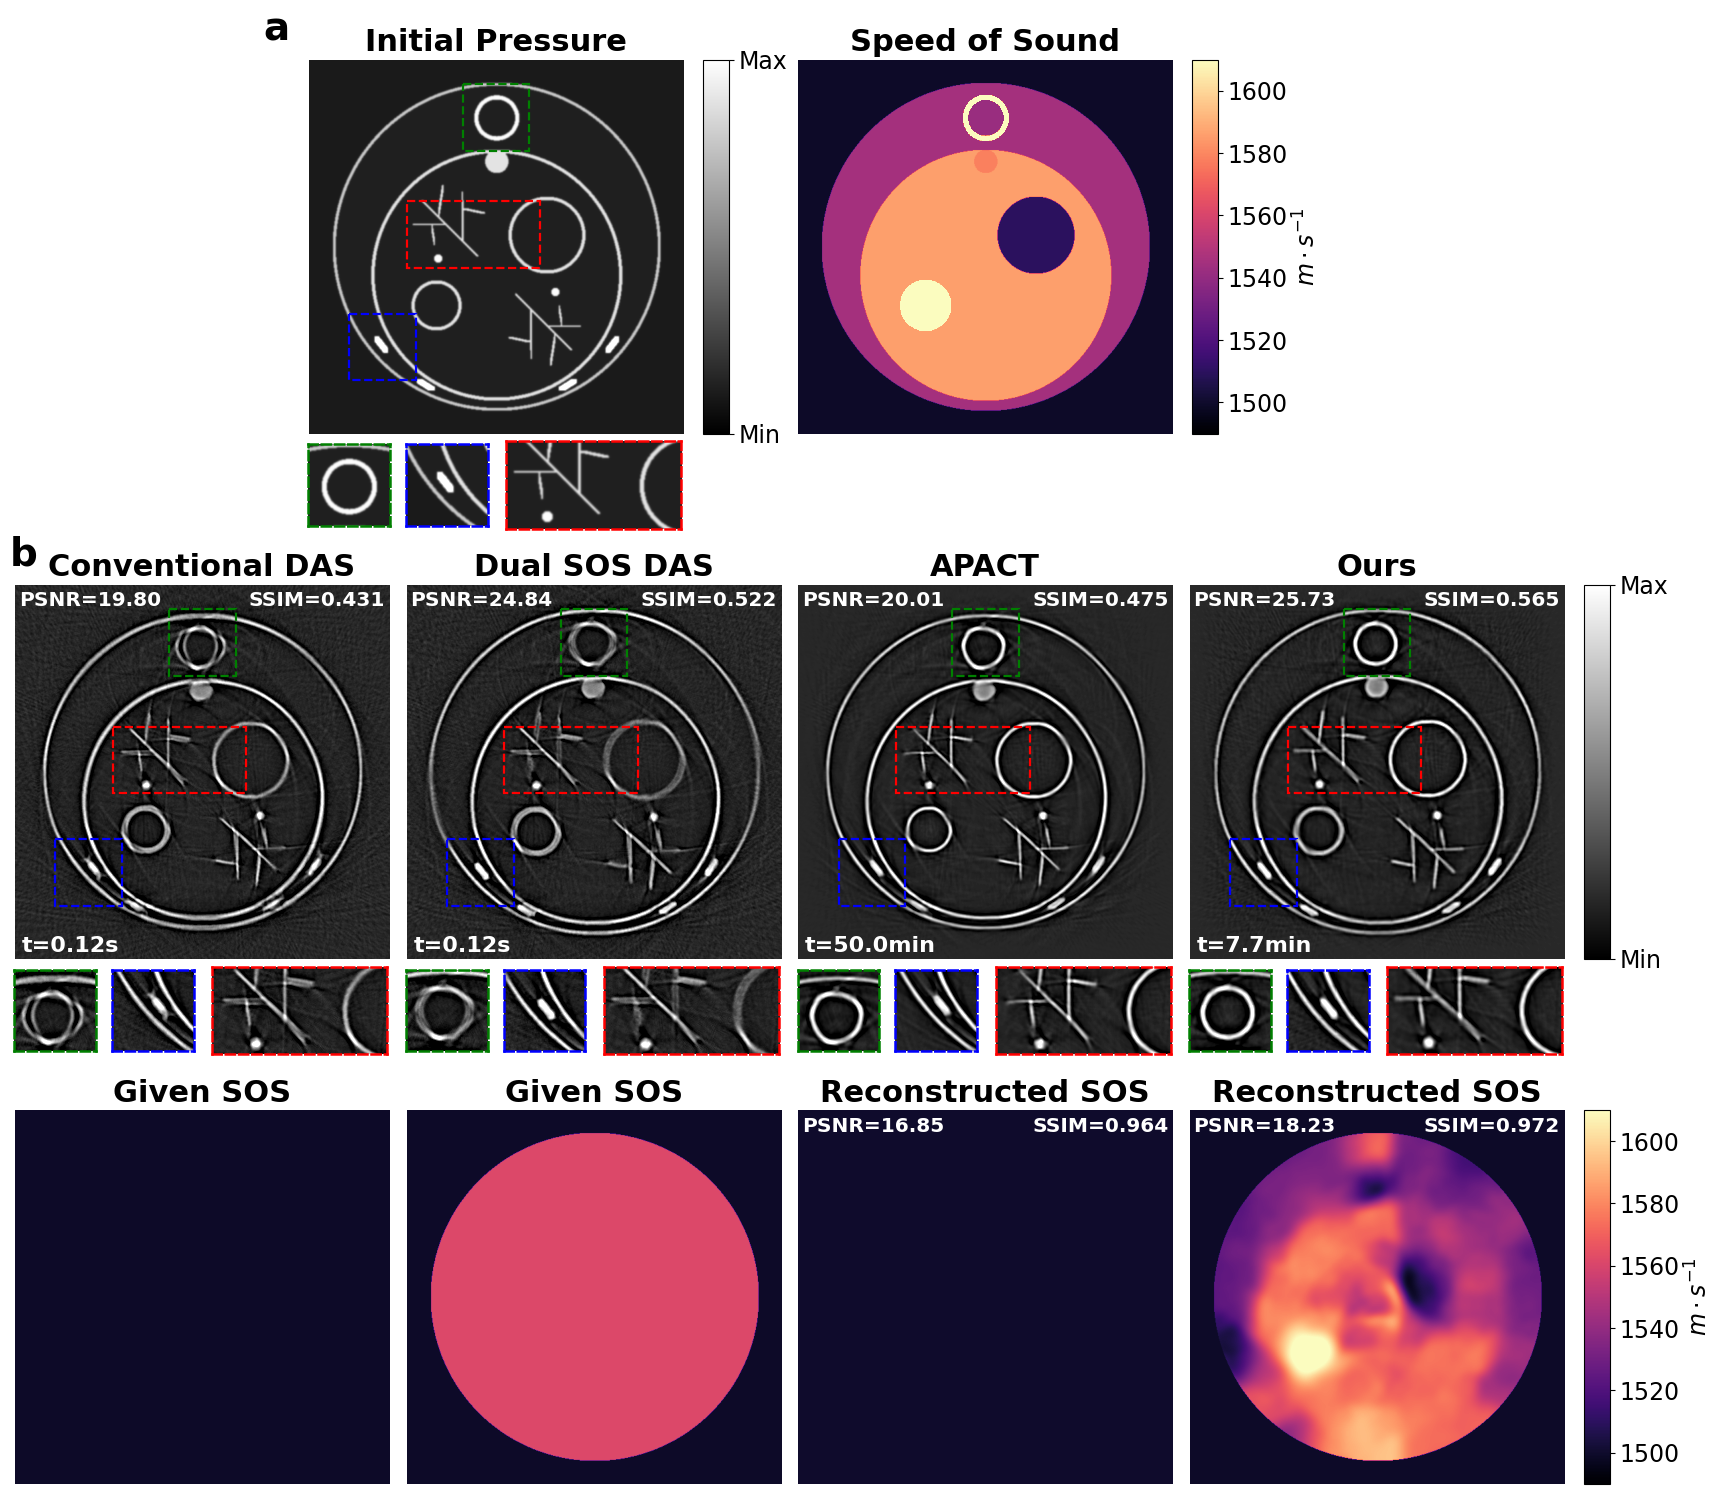

In [8]:
patches = [(36, 230, 100, 100, 'green'), (380, 60, 100, 100,'blue'), (212, 146, 100, 200, 'red')]

fig = plt.figure(figsize=(20, 18.5))
gs = GridSpec(30, 16)
norm = Normalize(vmax=5, vmin=-1)
norm_SOS = Normalize(vmax=1610, vmin=1490)

ax = plt.subplot(gs[0:8,3:7])
plt.title('a', loc='left', x=-0.12, y=1.03, fontsize=28, fontweight='semibold', color='black')
plt.title('Initial Pressure', fontsize=22, fontweight='semibold')
plt.axis('off')
plt.imshow(IP_gt, cmap='gray', norm=norm)
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.013, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.set_ticks([5, -1])
cb.set_ticklabels(['Max', 'Min'], fontsize=17)
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[8:10,3+k:3+k+1+(k==2)])
        plt.imshow(IP_gt[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(1.8)
            ax2.spines[loc].set_linestyle('--')

ax = plt.subplot(gs[0:8,8:12])
plt.axis('off')
plt.title('Speed of Sound', fontsize=22, fontweight='semibold')
plt.imshow(SOS_gt, cmap='magma', norm=norm_SOS)
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.013, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_SOS)
cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=17)
cb.set_label('$m \cdot s^{-1}$', fontsize=17)

for idx, (img, method, time, SOS, SOS_title) in enumerate(zip([IP_das, IP_dual_das, IP_apact, IP_nf_apact],
                                                              ['Conventional DAS', 'Dual SOS DAS', 'APACT', 'Ours'],
                                                              ['t={:.2f}s'.format(t_das), 't={:.2f}s'.format(t_dual_das), 't={:.1f}min'.format(t_apact/60), 't={:.1f}min'.format(t_nf_apact/60)],
                                                              [SOS_uniform, SOS_dual, SOS_APACT, SOS_nf_apact],
                                                              ['Given SOS', 'Given SOS', 'Reconstructed SOS', 'Reconstructed SOS'])):
    ax = plt.subplot(gs[11:19,idx*4:(idx+1)*4])
    plt.title(method, fontsize=22, fontweight='semibold')
    plt.axis('off')
    plt.imshow(img, cmap='gray', norm=norm)
    plt.text(s=time, x=10, y=550, fontweight='semibold', fontsize=16, color='white')
    plt.title('PSNR={:.2f}'.format(psnr(IP_gt, img, data_range=data_range_img)), loc='left', x=0.01, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
    plt.title('SSIM={:.3f}'.format(ssim(IP_gt, img, data_range=data_range_img)), loc='right', x=0.99, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
    if idx == 0:
        plt.text(s='b', x=-8, y=-30, fontsize=28, fontweight='semibold', color='black')
    elif idx == 3:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.013, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks([5, -1])
        cb.set_ticklabels(['Max', 'Min'], fontsize=17)
    
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.6, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[19:21,idx*4+k:idx*4+k+1+(k==2)])
        plt.imshow(img[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(1.8)
            ax2.spines[loc].set_linestyle('--')

    ax = plt.subplot(gs[22:30,idx*4:(idx+1)*4])
    plt.axis('off')
    plt.title(SOS_title, fontsize=22, fontweight='semibold')
    plt.imshow(SOS, cmap='magma', norm=norm_SOS)
    if idx >= 2:
        plt.title('PSNR={:.2f}'.format(psnr(SOS, SOS_gt, data_range=data_range_SOS)), loc='left', x=0.01, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
        plt.title('SSIM={:.3f}'.format(ssim(SOS, SOS_gt, data_range=data_range_SOS)), loc='right', x=0.99, y=0.92, fontsize=14.5, fontweight='semibold', color='white')
    if idx == 3:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.013, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=17)
        cb.set_label('$m \cdot s^{-1}$', fontsize=17)
    
plt.savefig('figure_simulation.png', bbox_inches='tight', dpi=256)